# The Problem

Gravitational waves (GW) are ripples in spacetime caused by the acceleration of massive objects. Predicted by Einstein in 1916, they travel at the speed of light, carrying information about their origins and the nature of gravity. The Laser Interferometer Gravitational-wave Observatory (LIGO) detects these waves using laser interferometers in Hanford, Washington, and Livingston, Louisiana. LIGO measures tiny distortions in spacetime caused by passing gravitational waves.

Having two LIGO interferometers is crucial because it allows for the verification of signals, distinguishing them from local noise and artifacts that are uncorrelated between the two locations. This dual setup also improves the localization of gravitational wave sources by comparing the arrival times of signals at each detector. Additionally, it enhances noise reduction and increases overall sensitivity, allowing for the detection of weaker signals.

To identify transient gravitational waves, scientists use matched filtering, comparing LIGO data with known templates from systems we can analytically or numerically calculate their gravitational-wave emission, like those from merging black holes. This method is effective for well-understood sources but less so for unknown phenomena where signal morphologies are poorly modeled or remain completely known.

The Anomaly Detection Challenge focuses on data from LIGO's O3 observations.  We provide several datasets,  Additionally, the dataset contains simulated signals injected into the real instrument data. Participants are tasked with training their models primarily on the instrument data to detect anomalies. They can also leverage information from the simulated signals to enhance their detection methods.

#### Known transient GW sources (detectable with matched-filtering pipelines)

- Binary Black Hole (BBH) Mergers

    * Two black holes orbiting each other and eventually merging. They produce strong and detectable gravitational waves during the final moments of the merger.

- Binary Neutron Star (BNS) Mergers

    * Two neutron stars spiraling together and merging. They emit gravitational waves as they orbit and merge, followed by electromagnetic signals in the full spectrum, including gamma-ray bursts.

- Black Hole - Neutron Star (BHNS) Mergers

    * A black hole and a neutron star in a binary system merging. They create gravitational waves and potentially a variety of electromagnetic emissions.

#### Unmodeled transient GW sources appearing as "anomalies" (not yet detected with matched-filtering pipeline)

- Supernovae

    * Explosive deaths of massive stars. They can produce gravitational waves, especially in cases where the explosion is asymmetric.

- Neutron Star Glitches

    * Sudden, small change in the spin frequency of pulsars may be associated with emission of transient gravitational-waves

- Cosmic Strings

    * Hypothetical one-dimensional topological defects in spacetime predicted by some theories of the early universe. They could produce bursts of gravitational waves when they interact or oscillate.

- Fast Radio Bursts, Gamma-Ray Bursts

    * Astrophysical phenomena/systems for which we do not have a complete picture of the progenitor but energetic enough to be plausibly associated with gravitational-wave emission

- Completely unknown/unthought of sources

    * GW detectors are fairly new instruments and the GW sky is largely unexplored &ndash; surprises with completely new astrophysical systems/sources are always a possibility!

These anomalies present a significant challenge and opportunity for innovation in gravitational wave transient detection, as their unpredictable nature makes them difficult to detect with traditional matched-filtering methods.

# Required libraries

- NumPy

- TensorFlow

- MatPlotLib

- SciKit-Learn

In [1]:
# Let's start with the necessary imports
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.regularizers import L1
from keras.optimizers import Adam
from keras.models import load_model

from matplotlib import pyplot as plt
from matplotlib import colors, lines
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Loading the data

The data we are using was provided to us via the [NSF HDR A3D3: Detecting Anomalous Gravitational Wave Signals Challenge](https://www.codabench.org/competitions/2626/). It contains $100$,$000$ cases of background data (data readings that do not constitute GW phenomena of any kind), $100$,$000$ cases of Binary Black Hole Merger (BBH) data (which is a known GW source, so we don't consider it anomalous), and $100$,$000$ cases of Sine-Gaussian Low Frequency (SGLF) data (which represents an anomalous GW source). These are gravitational-wave strain, $h(t)$ time series recorded by two LIGO interferometers including whitened, bandpass-filtered data from O3, with known GW events corresponding to binary coalesences removed. We are also going to normalize our data to make sure data cases are consistent and to ensure a smoother training process.

In [ ]:
# Loads the data and normalizes it

# Background data
background = np.load('background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]    # Standard deviation of the data
background = background/stds                            # Normalizing the data
background = np.swapaxes(background, 1, 2)

# Binary Black Hole (BBH) data
bbh = np.load('bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]           # Standard deviation of the data
bbh = bbh/stds                                          # Normalizing the data
bbh = np.swapaxes(bbh, 1, 2)

# Sine-Gaussian Low Frequency (SGLF) data
sglf = np.load('sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]          # Standard deviation of the data
sglf = sglf/stds                                        # Normalizing the data
sglf = np.swapaxes(sglf, 1, 2)

KeyboardInterrupt: 

Now that we have loaded the three different datasets, we can combine them and create matching labels for them ($1$ representing an anomalous GW source and $0$ representing anything else). We can just use the timeseries data for an unsupervised approach, while we can also use the labels for a supervised or semi-supervised approach.

In [ ]:
# Creates train and test datasets

# Concatenates the three different data sets and creates matching labels for them
data = np.concatenate((background, bbh, sglf), axis=0)
labels = np.concatenate((np.zeros(len(background)), np.zeros(len(bbh)), np.ones(len(sglf))), axis=0)[:, np.newaxis]

# Splits the complete dataset into train/test set using an 80/20 split.
x_train, x_test, y_train, y_test = train_test_split(
     data, labels, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape}/{x_test.shape}')
print(f'y train/test shapes: {y_train.shape}/{y_test.shape}')

x train/test shapes: (240000, 200, 2) (60000, 200, 2)
y train/test shapes: (240000, 1) (60000, 1)


In [ ]:
background_cov_indices = np.random.choice(background.shape[0], 10000, replace=False)
bbh_cov_indices = np.random.choice(bbh.shape[0], 10000, replace=False)
sglf_cov_indices = np.random.choice(sglf.shape[0], 10000, replace=False)

background_cov = background[background_cov_indices]
bbh_cov = bbh[bbh_cov_indices]
sglf_cov = sglf[sglf_cov_indices]

In [ ]:
# Create train and test datasets

data = np.concatenate((background_cov, bbh_cov, sglf_cov), axis=0)
labels = np.concatenate((np.zeros(len(background_cov)), np.zeros(len(bbh_cov)), np.ones(len(sglf_cov))), axis=0)[:, np.newaxis]

x_train, x_test, y_train, y_test = train_test_split(
     data, labels, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (24000, 200, 2) (6000, 200, 2)
y train/test shapes: (24000, 1) (6000, 1)


# Visualizing the data

To better understand the problem and decide on an approach, we should visualize the different data classes and see what similarities and differences they have:

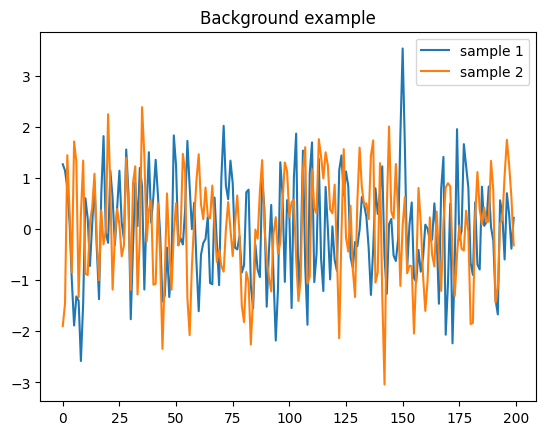

In [ ]:
# Creates the plot to visualize our data
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, constrained_layout=True)

# Plots a background data case
ax1.plot(background[0, :, 0])                           # Sample 1
ax1.plot(background[0, :, 1])                           # Sample 2
ax1.set_title("Background")                             # Title
ax1.set_xlabel("Timestep")                              # X axis label
ax1.set_ylabel("Spacetime Distortion")                  # Y axis label
ax1.set_xlim(-1, 200)                                   # Adjusts x axis
ax1.legend(["Sample 1", "Sample 2"], loc='upper left')  # Legend


# Plots a BBH data case
ax2.plot(bbh[0, :, 0])                                  # Sample 1
ax2.plot(bbh[0, :, 1])                                  # Sample 2
ax2.set_title("BBH")                                    # Title
ax2.set_xlabel("Timestep")                              # X axis label
ax2.set_ylabel("Spacetime Distortion")                  # Y axis label
ax2.set_xlim(-1, 200)                                   # Adjusts x axis
ax2.legend(["Sample 1", "Sample 2"], loc='lower left')  # Legend


# Plots a SGLF data case
ax3.plot(sglf[0, :, 0])                                 # Sample 1
ax3.plot(sglf[0, :, 1])                                 # Sample 2
ax3.set_title("SGLF")                                   # Title
ax3.set_xlabel("Timestep")                              # X axis label
ax3.set_ylabel("Spacetime Distortion")                  # Y axis label
ax3.set_xlim(-1, 200)                                   # Adjusts x axis
ax3.legend(["Sample 1", "Sample 2"], loc='lower left')  # Legend

# Shows the plots
fig.set_size_inches(6, 10)                              # Adjusts plot size
plt.show()
plt.close()

The BBH case is the most distinctive, with both samples following a sinusoidal pattern which seems to oscilate in opposite directions between samples. The background and SGLF cases seem to be very similar, but the SGLF case seems to have opposing peaks that almost perfectly coincide in the given timeframe, particularily between time 10-20 and 150-165. This seems to be the only noticeable difference between the background and SGLF cases, so we're going to focus on identifying this and detecting it with our model.

### Detecting correlations between samples in the data

To detect these correlations, we propose two approaches:

- Covariance matrices between samples

- Singular-Spectrum Analysis (SSA) of the data

#### Exploring covariance between samples

We can treat each sample as a random variable and plot a covariance matrix between the two. While this isn't an entirely appropriate framing of the data, as timeseries data observations are not independent between different timesteps, it can still serve as a valuable piece of information to identify correlations between samples. For this, we use NumPy to calculate the covariance between samples at all timesteps, which returns a $200 \times 200$ matrix which we can then visualize. Let's see what these covariance matrices look like for each of the classes:

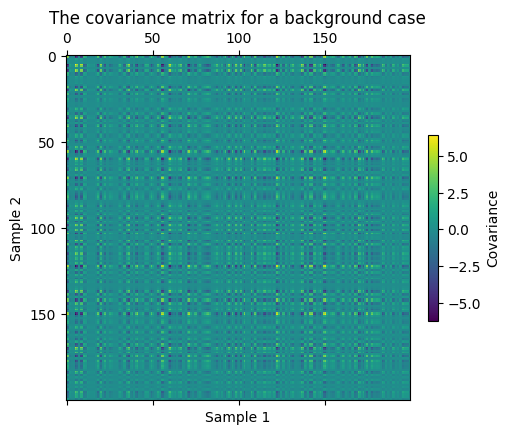

In [ ]:
# Creates the plot to visualize our data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True)

# Calculates the covariance matrices for each class
background_cov = np.cov(background[0])
bbh_cov = np.cov(bbh[0])
sglf_cov = np.cov(sglf[0])

# Establishes a norm for the color bar
norm = colors.Normalize(vmin=np.min([background_cov, bbh_cov, sglf_cov]), vmax=np.max([background_cov, bbh_cov, sglf_cov]))

# Plots the covariance matrix of a background data case
ax1.imshow(background_cov, norm=norm)           # Plots the matrix
ax1.set_xlabel("Sample 1")                      # X axis label
ax1.set_ylabel("Sample 2")                      # Y axis label
ax1.set_title("Background")                     # Title

# Plots the covariance matrix of a BBH data case
ax2.imshow(bbh_cov, norm=norm)                  # Plots the matrix
ax2.set_xlabel("Sample 1")                      # X axis label
ax2.set_ylabel("Sample 2")                      # Y axis label
ax2.set_title("BBH")                            # Title

# Plots the covariance matrix of a SGLF data case
ax3.imshow(sglf_cov, norm=norm)                 # Plots the matrix
ax3.set_xlabel("Sample 1")                      # X axis label
ax3.set_ylabel("Sample 2")                      # Y axis label
ax3.set_title("SGLF")                           # Title

# Adds a colorbar
fig.colorbar(ax1.imshow(background_cov, norm=norm), ax=(ax1, ax2, ax3), orientation='vertical', label='Covariance')

# Shows the plots
fig.suptitle('Covariance matrices per class')   # Super title (above previous titles)
fig.set_size_inches(10, 3)                      # Adjusts plot size
plt.show()
plt.close()

The covariance matrices are very noisy, but there seem to be differences between the three classes. The BBH case shows these large alternating squares in a checkered pattern. The SGLF case seems to have the same pattern with smaller squares, albeit pretty clouded by the noise. The background case might have a similar pattern with even smaller squares, but it seems to be a byproduct of the noise and therefore is not as clear as the other two cases. Given that these patterns seem clear enough to differentiate between cases, we can use this representation of the data for our approach.

#### Exploring Singular-Spectrum Analysis (SSA) of the data

[Analysis of Time Series Structure: SSA and Related Techniques](https://www.routledge.com/Analysis-of-Time-Series-Structure-SSA-and-Related-Techniques/Golyandina-Nekrutkin-Zhigljavsky/p/book/9781584881940) presents an intriguing approach to analyzing timeseries: we can decompose a trajectory matrix created from the timeseries to analyze its most important components. We referenced [this Kaggle article](https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition) in our development process, as it explains the methodology well and also provides a Python implementation which we used. In order to effectively describe our approach, we provide the most important information here. We will use the notation from [Analysis of Time Series Structure: SSA and Related Techniques](https://www.routledge.com/Analysis-of-Time-Series-Structure-SSA-and-Related-Techniques/Golyandina-Nekrutkin-Zhigljavsky/p/book/9781584881940), and all matrix and summation indexing with begin at 0 instead of 1 to preserve consistency between our mathematical notation and code.

Let $(f_0, \ f_{1}, \ldots , \ f_{N-1}) = F \in \mathbb{R}^N$ be the timeseries we are trying to analyze, and let $L \in \mathbb{N}$ be the window length $2 \le L \le N/2$. We form a 'window', given by the subseries $(f_i, \ f_{i+1}, \ldots , \ f_{i+L-1}) \in \mathbb{R}^L$, where $f_i \in F$, for  $i=0,\ldots,N-L$. We slide this window along the time series, forming a column vector, $X_i$, for each subseries, such that

\begin{align*}
X_0 & = (f_0, \ f_1, \ f_2,  \ldots, \ f_{L-1} )^{\text{T}} \\
X_1 & = (f_1, \ f_2, \ f_3,  \ldots, \ f_L )^{\text{T}} \\
X_2 & = (f_2, \ f_3, \ f_4,  \ldots, \ f_{L+1} )^{\text{T}} \\
X_3 & = (f_3, \ f_4, \ f_5,  \ldots, \ f_{L+2} )^{\text{T}} \\
& \quad \quad \quad  \vdots \\
X_{N-L} & = (f_{N-L}, \ f_{N-L+1}, \ f_{N-L+2}, \ \ldots, \ f_{N-1} )^{\text{T}}.
\end{align*}

These column vectors form the $L$-*trajectory matrix*, $\mathbf{X}$:

$$\mathbf{X} = \begin{bmatrix}
f_0 & f_1 & f_2 & f_3 &\ldots & f_{N-L} \\ 
f_1 & f_2 & f_3 & f_4 &\ldots & f_{N-L+1} \\
f_2 & f_3 & f_4 & f_5 &\ldots & f_{N-L+2} \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
f_{L-1} & f_{L} & f_{L+1} & f_{L+2} & \ldots & f_{N-1} \\ 
\end{bmatrix}$$

From writing out the matrix above, it is clear that the elements of the *anti-diagonals* (i.e. the diagonals running from bottom-left to top-right) are equal. This type of matrix is known as a *Hankel* matrix. Let's see what the $100$-*trajectory matrix* looks like for each of the classes:

In [ ]:
L = 100                         # The window length
K = background.shape[1] - L + 1 # The number of columns in the trajectory matrix

# Creates the trajectory matrix by pulling the relevant subseries of each class and stacking them as columns
X_background = np.stack([background[0][i:i + L] for i in range(0, K)], axis=1)
X_bbh = np.stack([bbh[0][i:i + L] for i in range(0, K)], axis=1)
X_sglf = np.stack([sglf[0][i:i + L] for i in range(0, K)], axis=1)


# Visualizes both samples from the background case

# Creates the plot to visualize our data
fig, (ax1, ax2) = plt.subplots(1, 2)

# Establishes a norm for the color bar
norm = colors.Normalize(vmin=np.min(X_background), vmax=np.max(X_background))

# Plots the 100-trajectory matrix for the first background sample
ax1.imshow(X_background[:, :, 0], norm=norm)            # Sample 1
ax1.set_xlabel("$L$-Lagged Vectors")                    # X axis label
ax1.set_ylabel("$K$-Lagged Vectors")                    # Y axis label
ax1.set_title("Sample 1")                               # Title

ax2.imshow(X_background[:, :, 1], norm=norm)            # Sample 2
ax2.set_xlabel("$L$-Lagged Vectors")                    # X axis label
ax2.set_ylabel("$K$-Lagged Vectors")                    # Y axis label
ax2.set_title("Sample 2")                               # Title

# Adds a colorbar
fig.colorbar(ax1.imshow(X_background[:, :, 0], norm=norm), ax=(ax1, ax2), orientation='vertical', label="$F(t)$")

# Shows the plots
fig.suptitle('Background $100$-trajectory matrices')    # Super title (above previous titles)
fig.set_size_inches(11, 4)                              # Adjusts plot size
plt.show()
plt.close()


# Visualizes both samples from the BBH case

# Creates the plot to visualize our data
fig, (ax1, ax2) = plt.subplots(1, 2)

# Establishes a norm for the color bar
norm = colors.Normalize(vmin=np.min(X_bbh), vmax=np.max(X_bbh))

# Plots the 100-trajectory matrix for the first background sample
ax1.imshow(X_bbh[:, :, 0], norm=norm)                   # Sample 1
ax1.set_xlabel("$L$-Lagged Vectors")                    # X axis label
ax1.set_ylabel("$K$-Lagged Vectors")                    # Y axis label
ax1.set_title("Sample 1")                               # Title

ax2.imshow(X_bbh[:, :, 1], norm=norm)                   # Sample 2
ax2.set_xlabel("$L$-Lagged Vectors")                    # X axis label
ax2.set_ylabel("$K$-Lagged Vectors")                    # Y axis label
ax2.set_title("Sample 2")                               # Title

# Adds a colorbar
fig.colorbar(ax1.imshow(X_bbh[:, :, 0], norm=norm), ax=(ax1, ax2), orientation='vertical', label="$F(t)$")

# Shows the plots
fig.suptitle('BBH $100$-trajectory matrices')           # Super title (above previous titles)
fig.set_size_inches(11, 4)                              # Adjusts plot size
plt.show()
plt.close()


# Visualizes both samples from the SGLF case

# Creates the plot to visualize our data
fig, (ax1, ax2) = plt.subplots(1, 2)

# Establishes a norm for the color bar
norm = colors.Normalize(vmin=np.min(X_sglf), vmax=np.max(X_sglf))

# Plots the 100-trajectory matrix for the first background sample
ax1.imshow(X_sglf[:, :, 0], norm=norm)                  # Sample 1
ax1.set_xlabel("$L$-Lagged Vectors")                    # X axis label
ax1.set_ylabel("$K$-Lagged Vectors")                    # Y axis label
ax1.set_title("Sample 1")                               # Title

ax2.imshow(X_sglf[:, :, 1], norm=norm)                  # Sample 2
ax2.set_xlabel("$L$-Lagged Vectors")                    # X axis label
ax2.set_ylabel("$K$-Lagged Vectors")                    # Y axis label
ax2.set_title("Sample 2")                               # Title

# Adds a colorbar
fig.colorbar(ax1.imshow(X_sglf[:, :, 0], norm=norm), ax=(ax1, ax2), orientation='vertical', label="$F(t)$")

# Shows the plots
fig.suptitle('SGLF $100$-trajectory matrices')          # Super title (above previous titles)
fig.set_size_inches(11, 4)                              # Adjusts plot size
plt.show()
plt.close()

(200, 2)
(100, 101, 2)


The $100$-*trajectory matrices* look good for all classes, as they are clearly *Hankel* matrices with visible patterns. We can now perform SSA on each sample by decomposing the trajectory matrix $\mathbf{X}$ using [singular-value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular-value_decomposition):

$$\mathbf{X} = \mathbf{U\Sigma V}^{\text{T}}$$ 
where:
* $\mathbf{U}$ is an $L \times L$ unitary matrix containing the orthonormal set of *left singular vectors* of $\mathbf{X}$ as columns;
* $\mathbf{\Sigma}$ is an $L \times K$ rectangular diagonal matrix containing $L$ *singular values* of $\mathbf{X}$, ordered from largest to smallest; and
* $\mathbf{V}$ is a $K \times K$ unitary matrix containing the orthonormal set of *right singular vectors* of $\mathbf{X}$ as columns.

The SVD of the trajectory matrix $\mathbf{X}$ can be rewritten as 
\begin{align*}
    \mathbf{X} & = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}} \\
               & \equiv \sum_{i=0}^{d-1}\mathbf{X}_i
\end{align*}
where $\sigma_i$ is the $i^\text{th}$ singular value, $U_i$ and $V_i$ are vectors representing the $i^\text{th}$ columns of $\mathbf{U}$ and $\mathbf{V}$, respectively, $d \le L$ is the *rank* of the trajectory matrix, and $\mathbf{X}_i = \sigma_i U_i V_i^{\text{T}}$ is the $i^\text{th}$ *elementary matrix* of $\mathbf{X}$. The collection $\{U_i, \sigma_i, V_i\}$ will be denoted the $i^\text{th}$ *eigentriple* of the SVD. The columns of the $\mathbf{U}$ matrix form an orthonormal basis set that describes the time subseries $(f_i, \ldots, f_{i+L-1})$ for $i=0, 1, \dots, N-L$ (the columns of the $\mathbf{X}$ matrix), the columns of the $\mathbf{V}$ matrix form an orthonormal basis set that describes the time subseries $(f_i, \ldots, f_{i+N-L})$ for $i=0, 1, \dots, L-1$ (the rows of the $\mathbf{X}$ matrix), and $\sigma_i$ is a scaling factor that determines the relative importance of the eigentriple $(U_i, \sigma_i, V_i)$ in the expansion $\mathbf{X} = \sum_{i=0}^{d-1}\mathbf{X}_i = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}}$, where $\mathbf{X}_i$ is the $i^\text{th}$ *elementary matrix* of $\mathbf{X}$. After sorting the elementary matrices by their scaling factor $\sigma_i$ in descending order, we can sum the first $r \leq d$ elementary matrices to obtain an optimal, lower-dimensional approximation of $\mathbf{X}$.

If you would like to know more details on how all of this works, we recommend reading [this Kaggle article](https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition). For now, let's see what the 8 most important elementary matrices for each sample look like:

In [ ]:
# Performs SVD on the background case
U, Sigma, V_T = np.linalg.svd(np.moveaxis(X_background, -1, 0))   # Reshapes X to allow NumPy to perform SVD on both samples at once

# Calculates the number of elementary matrices to visualize (can't be more than the matrix rank)
num_elementary_matrices = min(8, np.linalg.matrix_rank(X_background[:, :, 0]), np.linalg.matrix_rank(X_background[:, :, 1]))

# Creates a plot for us to visualize our elementary matrices
fig = plt.figure()

# Loops through the eigentriples and plots the resulting elementary matrices
for i in range(num_elementary_matrices):
    # Plots the elementary matrix for sample 1
    ax = fig.add_subplot(4, 4, i + (2 * (i//2)) + 1)
    ax.imshow(Sigma[0, i] * np.outer(U[0, :, i], V_T[0, i, :])) # Sample 1
    ax.set_xticks([])                                           # Adjusts x axis
    ax.set_yticks([])                                           # Adjusts y axis
    ax.set_title("$\mathbf{X}_{" + str(i) + "}$")               # Title

    # Plots the elementary matrix for sample 2
    ax = fig.add_subplot(4, 4, i + (2 * (i//2)) + 3)
    ax.imshow(Sigma[1, i] * np.outer(U[1, :, i], V_T[1, i, :])) # Sample 2
    ax.set_xticks([])                                           # Adjusts x axis
    ax.set_yticks([])                                           # Adjusts y axis
    ax.set_title("$\mathbf{X}_{" + str(i) + "}$")               # Title

# Sets the title for sample 1
plt.subplot(1, 2, 1, frame_on=False)
plt.xticks([])
plt.yticks([])
plt.title("Sample 1", pad=25)

# Sets the title for sample 2
plt.subplot(1, 2, 2, frame_on=False)
plt.xticks([])
plt.yticks([])
plt.title("Sample 2", pad=25)

# Sets the super title and separating line for the figure and shows the plot
fig.suptitle("Background Elementary Matrices")
fig.add_artist(lines.Line2D([0.5125, 0.5125], [0.94, 0.11], linewidth=1.5, color='k'))
fig.set_size_inches(8, 8)                                       # Adjusts plot size
plt.show()
plt.close()

# Performs SVD on the BBH case
U, Sigma, V_T = np.linalg.svd(np.moveaxis(X_bbh, -1, 0))   # Reshapes X to allow NumPy to perform SVD on both samples at once

# Calculates the number of elementary matrices to visualize (can't be more than the matrix rank)
num_elementary_matrices = min(8, np.linalg.matrix_rank(X_bbh[:, :, 0]), np.linalg.matrix_rank(X_bbh[:, :, 1]))

# Creates a plot for us to visualize our elementary matrices
fig = plt.figure()

# Loops through the eigentriples and plots the resulting elementary matrices
for i in range(num_elementary_matrices):
    # Plots the elementary matrix for sample 1
    ax = fig.add_subplot(4, 4, i + (2 * (i//2)) + 1)
    ax.imshow(Sigma[0, i] * np.outer(U[0, :, i], V_T[0, i, :])) # Sample 1
    ax.set_xticks([])                                           # Adjusts x axis
    ax.set_yticks([])                                           # Adjusts y axis
    ax.set_title("$\mathbf{X}_{" + str(i) + "}$")               # Title

    # Plots the elementary matrix for sample 2
    ax = fig.add_subplot(4, 4, i + (2 * (i//2)) + 3)
    ax.imshow(Sigma[1, i] * np.outer(U[1, :, i], V_T[1, i, :])) # Sample 2
    ax.set_xticks([])                                           # Adjusts x axis
    ax.set_yticks([])                                           # Adjusts y axis
    ax.set_title("$\mathbf{X}_{" + str(i) + "}$")               # Title

# Sets the title for sample 1
plt.subplot(1, 2, 1, frame_on=False)
plt.xticks([])
plt.yticks([])
plt.title("Sample 1", pad=25)

# Sets the title for sample 2
plt.subplot(1, 2, 2, frame_on=False)
plt.xticks([])
plt.yticks([])
plt.title("Sample 2", pad=25)

# Sets the title and separating line for the figure and shows the plot
fig.suptitle("BBH Elementary Matrices")
fig.add_artist(lines.Line2D([0.5125, 0.5125], [0.94, 0.11], linewidth=1.5, color='k'))
fig.set_size_inches(8, 8)                                       # Adjusts plot size
plt.show()
plt.close()

# Performs SVD on the SGLF case
U, Sigma, V_T = np.linalg.svd(np.moveaxis(X_sglf, -1, 0))   # Reshapes X to allow NumPy to perform SVD on both samples at once

# Calculates the number of elementary matrices to visualize (can't be more than the matrix rank)
num_elementary_matrices = min(8, np.linalg.matrix_rank(X_sglf[:, :, 0]), np.linalg.matrix_rank(X_sglf[:, :, 1]))

# Creates a plot for us to visualize our elementary matrices
fig = plt.figure()

# Loops through the eigentriples and plots the resulting elementary matrices
for i in range(num_elementary_matrices):
    # Plots the elementary matrix for sample 1
    ax = fig.add_subplot(4, 4, i + (2 * (i//2)) + 1)
    ax.imshow(Sigma[0, i] * np.outer(U[0, :, i], V_T[0, i, :])) # Sample 1
    ax.set_xticks([])                                           # Adjusts x axis
    ax.set_yticks([])                                           # Adjusts y axis
    ax.set_title("$\mathbf{X}_{" + str(i) + "}$")               # Title

    # Plots the elementary matrix for sample 2
    ax = fig.add_subplot(4, 4, i + (2 * (i//2)) + 3)
    ax.imshow(Sigma[1, i] * np.outer(U[1, :, i], V_T[1, i, :])) # Sample 2
    ax.set_xticks([])                                           # Adjusts x axis
    ax.set_yticks([])                                           # Adjusts y axis
    ax.set_title("$\mathbf{X}_{" + str(i) + "}$")               # Title

# Sets the title for sample 1
plt.subplot(1, 2, 1, frame_on=False)
plt.xticks([])
plt.yticks([])
plt.title("Sample 1", pad=25)

# Sets the title for sample 2
plt.subplot(1, 2, 2, frame_on=False)
plt.xticks([])
plt.yticks([])
plt.title("Sample 2", pad=25)

# Sets the title and separating line for the figure and shows the plot
fig.suptitle("SGLF Elementary Matrices")
fig.add_artist(lines.Line2D([0.5125, 0.5125], [0.94, 0.11], linewidth=1.5, color='k'))
fig.set_size_inches(8, 8)                                       # Adjusts plot size
plt.show()
plt.close()

With SSA, the differences between classes become clearer. The BBH case contains elementary matrices with high associated singular values that contain large square chunks alternating in a checkered pattern. The SGLF case also contains a simiplar pattern with smaller squares in high-importance elementary matrices. The background case seems to be very noisy at best, providing no discernible patterns. We could already see this behavior from looking at the covariance matrix of each class earlier, but SSA seems to remove most of the noise from that approach, although it treats samples from the same case separately instead of looking at them together, like the covariance approach did. Regardless, given these patterns are clear enough to distinguish, we can use this representation of the data in our approach.

# Picking an approach

We have three data representations that we can use for our model:

- The normalized timeseries data, representing space-time distortions over 200 timesteps recorded by two LIGO laser interferometers.

- Covariance matrices, extracted from calculating the covariance between both samples over all timesteps, treating each timestep as an observation of a random variable.

- Elementary matrices, extracted from performing Singular-Spectrum Analysis (SSA) on the timeseries data.

Each one has their advantages and disadvantages. The normalized timeseries data is the purest form of the data and likely contains the most information, but its patterns may be too complex or subtle to detect without pre-processing. The covariance matrices provide the clearest representation of the correlation between samples, but it's noisy and is based on the flawed assumption that timesteps are independent from each other. The elementary matrices provide clear different patterns between the classes, but they treat each sample independently from each other and there's a limit to how many matrices we can process. Let's look at how we would leverage each data representation.

## Normalized timeseries data

We can utilize attention to capture the temporal relationships between timestep observations and hopefully classify the data cases based off of the learned features. This would require us to use an encoder-decoder architecture, as it would be impractical to try to use a transformer architecture alone to encode the timeseries data into a prediction by itself. Instead, we propose using the following architecture:

<center><img src="img/Transformer_Encoder-Decoder_Network_Architecture.png" alt="Transformer Encoder-Decoder Architecture" width="600"/></center>

A dense feed-forward decoder architecture should be good enough to combine the features learned by the transformer encoder, especially if we use non-linear activation functions. However, given the complexity of the architecture, and the limited information that binary labels provide on their own, the model might be sensitive to initialization, as there could be multiple local minima in the loss function that do not correspond to the global minimum, meaning that different initializations could yield vastly different results. A problem that would be easier to solve would be recontructing the input timeseries using an **autoencoder**, as the timeseries data is much more informative than a single 0/1 label. This network would try to reconstruct the input data by learning a set of features from it, then using those features to assign values at each timestep, trying to minimize the difference between the input data and the reconstruction. This is essentially equivalent to the following: let $x \in \mathbb{R}^N$ be our input timeseries, and let $f: \mathbb{R}^N \to \mathbb{R}^M$ and $g: \mathbb{R}^M \to \mathbb{R}^N$, where $M \leq N$. Then we are using the autoencoder to find $f(x)$ and $g(x)$ such that $x \approx g(f(x))$, that is, we try to minimize $|x - g(f(x))|_2^2$.

<center><img src="img/Transformer_Autoencoder_Network_Architecture.png" alt="Transformer Autoencoder Architecture" width="575"/></center>

Unfortunately, this isn't the problem we're trying to solve. However, we can train the transformer encoder on this task, as it's similar enough to our classification task, then use the learned parameters as an initialization for the transformer encoder in our classification model. This is what's known as **transfer learning**, and it consists of **pre-training** a model on a task, then deploying for a similar task, using an **adaptive layer** to adapt its output on one task to equivalent outputs for another task, and **fine-tuning** the transferred model to mitigate some of the differences between tasks. Please note that, while the transformer encoder architecture will be the same for both the autoencoder and the encoder-decoder networks, the dense decoder will have different architectures, as the dimensionality of the output is different.

<center><img src="img/Transfer_Learning_Approach.png" alt="Transfer Learning Approach" width="750"/></center>

### Building the autoencoder

The autoencoder we are going to use was provided to us via the starter code for the [NSF HDR A3D3: Detecting Anomalous Gravitational Wave Signals Challenge](https://www.codabench.org/competitions/2626/). We simply cleaned up the code and added L1 regularization.

Our model processes a tensor of shape `(batch size, sequence length, features)`, where `sequence length` is the number of time steps and `features` is each input timeseries sample. The output is a tensor of shape `(batch size, sequence length, features)`, where `sequence length` is the number of time steps and `features` is each output timeseries sample.

The model includes the following components:

- `Transformer Encoder`: includes residual connections, layer normalization, dropout, L1 regularization and multi-head attention layers. The projection layers are implemented using `keras.layers.Conv1D`. This layer can be stacked multiple times.

- `Dense Decoder`: after the transformer encoder, the dense decoder is used. It flattens the input, applies several dense layers with residual connections, dropout, and layer normalization, and then reshapes the output back to the original input shape.

The final layer of the model is a dense layer that outputs a tensor of the same shape as the input.


In [ ]:
class Autoencoder:
    """This class represents an autoencoder that takes input of shape (batch
    size, sequence length, features) and outputs a reconstructed version of the
    same input with shape (batch size, sequence length, features). It consists
    of an encoder that contains one or multiple transformer blocks and a dense
    decoder, with a final dense layer that ensures the output has the correct
    shape. The implementation includes residual connections, layer
    normalization, dropout, L1 regularization, multi-head attention layers, 1D
    convolutional layers, and dense feed-forward layers using ReLu activation.
    For training, the model uses MSE loss and an Adam optimizer.

    Attributes
    ----------
    encoder : keras.Model
        The transformer encoder part of the autoencoder
    decoder : keras.Model
        The dense feed-forward decoder part of the autoencoder
    autoencoder : keras.Model
        The full autoencoder
    
    Methods
    -------
    build_encoder(self, inputs, head_size, num_heads, ff_dim, l1=0,
                  epsilon=1e-6, dropout=0)
        Builds the transformer encoder part of the autoencoder
    build_decoder(self, inputs, ff_dim, output_dim, l1=0, dropout=0)
        Builds the dense feed-forward decoder part of the autoencoder
    build_model(self, input_shape, head_size, num_heads, projection_dim,
                ff_dim, num_transformer_blocks, l1=0, epsilon=1e-6, dropout=0)
        Builds the autoencoder
    save(self, path='')
        Saves the autoencoder
    save_encoder(self, path='')
        Saves the encoder
    save_decoder(self, path='')
        Saves the decoder
    load(self, path='')
        Loads the autoencoder
    load_encoder(self, path='')
        Loads the encoder
    load_decoder(self, path='')
        Loads the decoder
    fit(self, x_train, **kwargs)
        Fits the autoencoder to some timeseries data
    """
    def __init__(self):
        super().__init__()
        self.encoder = None         # The model's encoder
        self.decoder = None         # The model's decoder
        self.autoencoder = None     # The full model
    

    def build_encoder(self, input_shape, num_transformer_blocks, head_size,
                      num_heads, projection_dim, l1=0, epsilon=1e-6,
                      dropout=0):
        """Builds the transformer encoder part of the autoencoder

        Parameters
        ----------
        input_shape : int tuple
            The shape of the input without including batch size
        num_transformer_blocks : int
            Number of transformer blocks for the encoder
        head_size : int
            The size of each attention head
        num_heads : int
            The number of attention heads
        projection_dim : int
            Number of internal units for the 1D convolutional projection
        l1 : float, optional
            The L1 regularization coefficient (default is 0)
        epsilon : float, optional
            The layer normalization coefficient (default is 1e-6)
        dropout : float, optional
            The dropout probability (default is 0)

        Returns
        -------
        int tuple
            Shape of the outputs
        """

        # Creates the placeholder inputs
        inputs = keras.Input(shape=input_shape)
        outputs = inputs    # To make the loop work

        # Creates one transformer block per the number of blocks specified
        for _ in range(num_transformer_blocks):
            x = layers.MultiHeadAttention(key_dim=head_size,
                                          num_heads=num_heads, dropout=dropout,
                                          kernel_regularizer=L1(l1))(outputs,
                                                                     outputs)
            x = layers.Dropout(dropout)(x)
            x = layers.LayerNormalization(epsilon=epsilon)(x)
            res = x + outputs   # Residual layer

            x = layers.Conv1D(filters=projection_dim, kernel_size=1,
                          kernel_regularizer=L1(l1), activation="relu")(res)
            x = layers.Dropout(dropout)(x)
            x = layers.Conv1D(filters=input_shape[-1], kernel_size=1,
                          kernel_regularizer=L1(l1))(x)
            x = layers.LayerNormalization(epsilon=epsilon)(x)
            outputs = x + res   # Residual layer

        # Saves the encoder
        self.encoder = keras.Model(inputs, outputs)

        # Returns the shape of the outputs
        return outputs.shape


    def build_decoder(self, input_shape, ff_dim, l1=0, epsilon=1e-6,
                      dropout=0):
        """Builds the dense feed-foward decoder part of the autoencoder

        Parameters
        ----------
        input_shape : int tuple
            The shape of the input without including batch size
        ff_dim : int
            Number of internal units for the dense feed-forward layers
        l1 : float, optional
            The L1 regularization coefficient (default is 0)
        epsilon : float, optional
            The layer normalization coefficient (default is 1e-6)
        dropout : float, optional
            The dropout probability (default is 0)

        Returns
        -------
        int tuple
            Shape of the outputs
        """

        # Creates the placeholder inputs
        inputs = keras.Input(shape=input_shape)

        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, kernel_regularizer=L1(l1), activation="relu")(
                         x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=epsilon)(x)
        # Aligns dimensions for residual
        res = layers.Dense(ff_dim, kernel_regularizer=L1(l1))(x)

        x = layers.Dense(ff_dim, kernel_regularizer=L1(l1), activation="relu")(
                         x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=epsilon)(x)
        x = x + res             # Residual layer

        x = layers.Dense(ff_dim, kernel_regularizer=L1(l1), activation="relu")(
                         x)
        x = layers.Dropout(dropout)(x)
        # Projects to a flattened input shape
        x = layers.Dense(np.prod(inputs.shape[1:]), kernel_regularizer=L1(l1))(
                         x)
        x = layers.LayerNormalization(epsilon=epsilon)(x)

        # Reshapes to the input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        outputs = x + inputs    # Residual layer

        # Saves the decoder
        self.decoder = keras.Model(inputs, outputs)

        # Returns the shape of the outputs
        return outputs.shape


    def build_model(self, input_shape, head_size, num_heads, projection_dim,
                    ff_dim, num_transformer_blocks, l1=0, epsilon=1e-6,
                    dropout=0):
        """Builds the autoencoder

        Parameters
        ----------
        input_shape : int tuple
            The shape of the input without including batch size
        head_size : int
            The size of each attention head
        num_heads : int
            The number of attention heads
        projection_dim : int
            Number of internal units for the 1D convolutional projection
        ff_dim : int
            Number of internal units for the dense feed-forward layers
        num_transformer_blocks : int
            Number of transformer blocks for the encoder
        l1 : float, optional
            The L1 regularization coefficient (default is 0)
        epsilon : float, optional
            The layer normalization coefficient (default is 1e-6)
        dropout : float, optional
            The dropout probability (default is 0)
        """

        # Encoder
        if not self.encoder:
            output_shape = self.build_encoder(input_shape,
                                              num_transformer_blocks,
                                              head_size, num_heads,
                                              projection_dim, l1, epsilon,
                                              dropout)[1:]

        # Decoder
        if not self.decoder:
            self.build_decoder(output_shape, ff_dim, l1, epsilon,
                               dropout)

        # Runs placeholder inputs through the model
        inputs = keras.Input(shape=input_shape)
        x = self.encoder(x)
        x = self.decoder(x)
        outputs = layers.Dense(input_shape[-1])(x)  # Output layer

        # Defines and compiles the autoencoder
        self.autoencoder = keras.Model(inputs, outputs)
        self.autoencoder.compile(loss='mse',
                                 optimizer=Adam(learning_rate=1e-4))


    def __call__(self, inputs, batch_size=64):
        """Performs a forward pass through the autoencoder

        Parameters
        ----------
        inputs : Any
            The inputs to process
        batch_size : int, optional
            Batch size for the processing (default is 64)

        Returns
        -------
        Any
            Result of the forward pass
        """

        return self.autoencoder.predict(inputs, batch_size=batch_size)


    def save(self, path=''):
        """Saves the autoencoder

        Parameters
        ----------
        path : str, optional
            The path to the folder in which to save the autoencoder (default is
            '')
        """

        self.autoencoder.save(os.path.join(path, 'autoencoder.keras'))


    def save_encoder(self, path=''):
        """Saves the encoder

        Parameters
        ----------
        path : str, optional
            The path to the folder in which to save the encoder (default is '')
        """
        
        self.encoder.save(os.path.join(path, 'transformer_encoder.keras'))


    def save_decoder(self, path=''):
        """Saves the decoder

        Parameters
        ----------
        path : str, optional
            The path to the folder in which to save the decoder (default is '')
        """
        
        self.decoder.save(os.path.join(path, 'dense_decoder.keras'))


    def load(self, path=''):
        """Loads the autoencoder

        Parameters
        ----------
        path : str, optional
            The path to the folder from which to load the autoencoder (default
            is '')
        """

        self.autoencoder = load_model(os.path.join(path,
                                                   'autoencoder.keras'))


    def load_encoder(self, path=''):
        """Loads the encoder

        Parameters
        ----------
        path : str, optional
            The path to the folder from which to load the encoder (default is
            '')
        """

        self.encoder = load_model(os.path.join(path,
                                               'transformer_encoder.keras'))


    def load_decoder(self, path=''):
        """Loads the decoder

        Parameters
        ----------
        path : str, optional
            The path to the folder from which to load the decoder (default is
            '')
        """

        self.decoder = load_model(os.path.join(path, 'dense_decoder.keras'))


    def fit(self, x_train, **kwargs):
        """Fits the autoencoder to some timeseries data

        Parameters
        ----------
        x_train : Any
            Training timeseries data
        **validation_split : float
            Proportion of data to be used for the validation set
        **epochs : int
            Number of epochs to train
        **batch_size : int
            Batch size to use during training
        **callbacks : keras.callbacks list
            Collection of callbacks to use during training

        Returns
        -------
        dict
            A dictionary with lists of performance metrics
        """

        return self.autoencoder.fit(x_train, x_train, **kwargs)

Now that we have defined our Autoencoder class, let's train it on our data:

In [ ]:
# Hyperparameters for the autoencoder
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
projection_dim = 64
ff_dim = 64
num_transformer_blocks = 2
l1 = 0.1
epsilon = 1e-6
dropout = 0.1

# Builds the model
autoencoder = Autoencoder()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    projection_dim=projection_dim,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    l1=l1,
    epsilon=epsilon,
    dropout=dropout
)

# Fits the autoencoder to the training data
history = autoencoder.fit(
    x_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

In [3]:
plt.figure()
plt.plot(x_test[0, :, 0])
plt.plot(x_test[0, :, 1])
plt.title("Before autoencoder")
plt.legend(["sample 1", "sample 2"], loc="best")
plt.show()
plt.close()

NameError: name 'plt' is not defined

In [ ]:
# Save the entire model as a SavedModel.
__file__=''
!mkdir -p saved_model
autoencoder.save('')

In [ ]:
plt.figure()
plt.plot(x_test[0, :, 0])
plt.plot(autoencoder.predict(x_test[0, :, 0]))
plt.title("Autoencoder in action 1")
plt.legend(["original", "reconstructed"], loc="best")
plt.show()
plt.close()

plt.figure()
plt.plot(x_test[0, :, 1])
plt.plot(autoencoder.predict(x_test[0, :, 1]))
plt.title("Autoencoder in action 2")
plt.legend(["original", "reconstructed"], loc="best")
plt.show()
plt.close()

NameError: name 'plt' is not defined

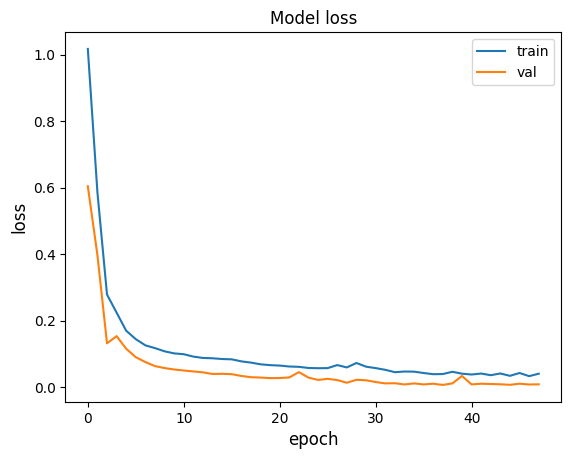

In [ ]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


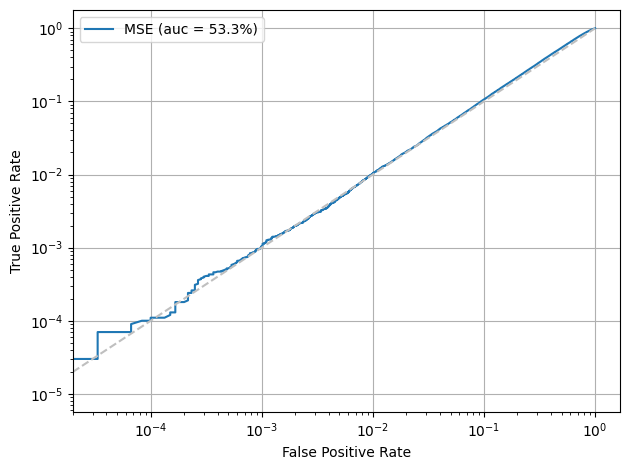

In [ ]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh)

make_plot_roc_curves(background_test, signal_test)

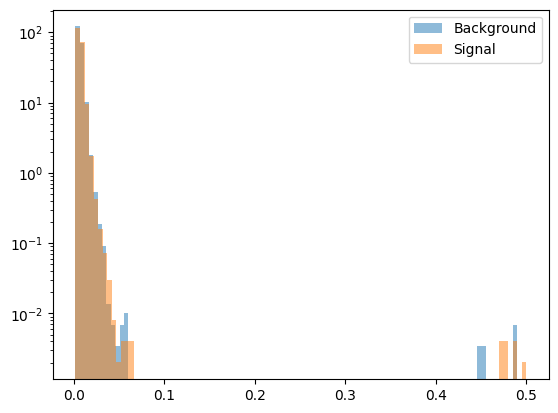

In [ ]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [ ]:
cov_matrix_list = []
for i in range(background.shape[0]):
    cov_matrix_list.append(np.cov(background[i]))

cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

In [ ]:
class Covariance_Model:
    def __init__(self):
        super().__init__()

    def conv_encoder(self, inputs, ff_dim, kernel_size, strides=1, dropout=0):
        x = layers.Conv2D(filters=16, kernel_size=kernel_size, strides=strides, activation="relu")(inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.MaxPool2D((3, 3))(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters=8, kernel_size=kernel_size, strides=strides, activation="relu")(inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.MaxPool2D((3, 3))(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters=1, kernel_size=x.shape[1], activation='sigmoid')(x)
        x = layers.Flatten()(x)

        return x

    def dense_predictor(self, inputs, pred_dim, dropout=0):
        # Flattens the input to apply dense layers
        x = layers.Flatten()(inputs)

        current_units = int(np.power(2, np.ceil(np.log2(x.shape[-1]))))

        while(current_units > pred_dim):
          current_units //= 2
          x = layers.Dense(current_units, activation="relu")(x)
          x = layers.Dropout(dropout)(x)
          x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Calculates probabilities for prediction
        x = layers.Dense(1, activation="sigmoid")(x)
        return x

    def build_model(self, input_shape, kernel_size, ff_dim, pred_dim, strides=1, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs

        outputs = self.conv_encoder(x, ff_dim=ff_dim, kernel_size=kernel_size, strides=strides)

        print(f"Incoming shape: {x.shape}")

        # Predictor
        # outputs = self.dense_predictor(x, pred_dim, dropout)

        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                   keras.metrics.TruePositives(name='tp'),
                   keras.metrics.FalsePositives(name='fp'),
                   keras.metrics.TrueNegatives(name='tn'),
                   keras.metrics.FalseNegatives(name='fn')]

        self.model = keras.Model(inputs, outputs)
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                           metrics=metrics)

    def predict(self, X, batch_size=32):
        return np.where(self.model.predict(X, batch_size=batch_size) >= 0.5, 1, 0)

    def __call__(self, inputs, batch_size=64):
        return self.model.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.model.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.model = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, y_train, epochs=1, validation_split=0.0, **kwargs):
      if validation_split > 0:
        x_train, x_val, y_train, y_val = train_test_split(
            data, labels, test_size=validation_split, random_state=42)

      if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
      else:
        batch_size = 1

      for i in range(epochs):
        print(f"Epoch {i + 1}/{epochs}:")
        num_batches = int(np.ceil(x_train.shape[0]/batch_size))
        training_metrics = np.zeros(6)
        batch_index = 0
        training_loss = 0.0
        training_accuracy = 0.0
        training_tp = 0.0
        training_tn = 0.0
        training_fp = 0.0
        training_fn = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        val_tp = 0.0
        val_tn = 0.0
        val_fp = 0.0
        val_fn = 0.0

        for batch_number in range(num_batches):
          batch_x, batch_y = x_train[batch_index:min(batch_index + batch_size, x_train.shape[0])], y_train[batch_index:min(batch_index + batch_size, y_train.shape[0])]
          cov_matrix_list = []
          for i in range(batch_x.shape[0]):
            cov_matrix_list.append(np.cov(batch_x[i]))

          cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

          # print(f"Processing batch {batch_number + 1}/{num_batches}")
          training_metrics = self.model.train_on_batch(cov_matrix, batch_y, class_weight={0:0.67, 1:1.33}, return_dict=True)
          training_loss += training_metrics['loss']/num_batches
          training_accuracy += training_metrics['accuracy']/num_batches
          training_tp += training_metrics['tp']
          training_tn += training_metrics['tn']
          training_fp += training_metrics['fp']
          training_fn += training_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Training metrics: loss = {training_loss}, accuracy = {training_accuracy}, TP = {training_tp}, TN = {training_tn}, FP = {training_fp}, FN = {training_fn}")

        num_batches = int(np.ceil(x_val.shape[0]/batch_size))
        val_metrics = np.zeros(6)
        batch_index = 0
        for batch_number in range(num_batches):
          batch_x, batch_y = x_val[batch_index:min(batch_index + batch_size, x_val.shape[0])], y_val[batch_index:min(batch_index + batch_size, y_val.shape[0])]
          cov_matrix_list = []
          for i in range(batch_x.shape[0]):
            cov_matrix_list.append(np.cov(batch_x[i]))

          cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

          val_metrics = self.model.test_on_batch(cov_matrix, batch_y, return_dict=True)
          val_loss += val_metrics['loss']/num_batches
          val_accuracy += val_metrics['accuracy']/num_batches
          val_tp += val_metrics['tp']
          val_tn += val_metrics['tn']
          val_fp += val_metrics['fp']
          val_fn += val_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Validation metrics: loss = {val_loss}, accuracy = {val_accuracy}, TP = {val_tp}, TN = {val_tn}, FP = {val_fp}, FN = {val_fn}")

      return training_metrics, val_metrics

# Example usage:
input_shape = (x_train.shape[1], x_train.shape[1], 1)
kernel_size = 20
strides = 5
ff_dim = 64
pred_dim = 64
dropout = 0.1
fine_tuning_split = 0.0

# build the model
predictor = Covariance_Model()
predictor.build_model(
    input_shape=input_shape,
    kernel_size=kernel_size,
    strides=strides,
    ff_dim=ff_dim,
    pred_dim=pred_dim,
    dropout=dropout
)

# Assuming x_train is your input data
training_loss, val_loss = predictor.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Incoming shape: (None, 200, 200, 1)
Epoch 1/20:
Training metrics: loss = 0.2527904891173045, accuracy = 0.8774166666666626, TP = 34232.0, TN = 71058.0, FP = 8929.0, FN = 5781.0
Validation metrics: loss = 0.1605173025383498, accuracy = 0.9384550462399445, TP = 9326.0, TN = 18828.0, FP = 1185.0, FN = 661.0
Epoch 2/20:
Training metrics: loss = 0.11067365287840385, accuracy = 0.9579916666666755, TP = 37508.0, TN = 77451.0, FP = 2536.0, FN = 2505.0
Validation metrics: loss = 0.11231467220733665, accuracy = 0.9596992714572802, TP = 9474.0, TN = 19317.0, FP = 696.0, FN = 513.0
Epoch 3/20:
Training metrics: loss = 0.08566587781161081, accuracy = 0.9686083333333476, TP = 38141.0, TN = 78092.0, FP = 1895.0, FN = 1872.0
Validation metrics: loss = 0.09607136278931515, accuracy = 0.9656960731630374, TP = 9514.0, TN = 19457.0, FP = 556.0, FN = 473.0
Epoch 4/20:
Training metrics: loss = 0.07433319678703944, accuracy = 0.9726083333333496, TP = 38406.0, TN = 78307.0, FP = 1680.0, FN = 1607.0
Validation

KeyboardInterrupt: 

In [ ]:
__file__='saved_model'
!mkdir -p saved_model
predictor.save('')

In [ ]:
class SSA_Model:
    def __init__(self):
        super().__init__()

    def conv_encoder(self, inputs, ff_dim, kernel_size, strides=1, dropout=0):
        x = layers.Conv2D(filters=16, kernel_size=kernel_size, strides=strides, activation="relu")(inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.MaxPool2D((3, 3))(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters=8, kernel_size=kernel_size, strides=strides, activation="relu")(inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.MaxPool2D((3, 3))(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = layers.Conv2D(filters=1, kernel_size=(x.shape[1], x.shape[2]), activation='sigmoid')(x)
        x = layers.Flatten()(x)

        return x

    def dense_predictor(self, inputs, pred_dim, dropout=0):
        # Flattens the input to apply dense layers
        x = layers.Flatten()(inputs)

        current_units = int(np.power(2, np.ceil(np.log2(x.shape[-1]))))

        while(current_units > pred_dim):
          current_units //= 2
          x = layers.Dense(current_units, activation="relu")(x)
          x = layers.Dropout(dropout)(x)
          x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Calculates probabilities for prediction
        x = layers.Dense(1, activation="sigmoid")(x)
        return x

    def build_model(self, input_shape, kernel_size, ff_dim, pred_dim, strides=1, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs

        outputs = self.conv_encoder(x, ff_dim=ff_dim, kernel_size=kernel_size, strides=strides)

        # Predictor
        # outputs = self.dense_predictor(x, pred_dim, dropout)

        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                   keras.metrics.TruePositives(name='tp'),
                   keras.metrics.FalsePositives(name='fp'),
                   keras.metrics.TrueNegatives(name='tn'),
                   keras.metrics.FalseNegatives(name='fn')]

        self.model = keras.Model(inputs, outputs)
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                           metrics=metrics)

    def predict(self, X, batch_size=32):
        return np.where(self.model.predict(X, batch_size=batch_size) >= 0.5, 1, 0)

    def __call__(self, inputs, batch_size=64):
        return self.model.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.model.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.model = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, y_train, epochs=1, validation_split=0.0, **kwargs):
      L = 100 # The window length.
      K = x_train.shape[1] - L + 1

      if validation_split > 0:
        x_train, x_val, y_train, y_val = train_test_split(
            data, labels, test_size=validation_split, random_state=42)

      if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
      else:
        batch_size = 1

      if 'num_components' in kwargs:
        num_components = kwargs['num_components']
      else:
        num_components = 8

      for i in range(epochs):
        print(f"Epoch {i + 1}/{epochs}:")
        num_batches = int(np.ceil(x_train.shape[0]/batch_size))
        training_metrics = np.zeros(6)
        batch_index = 0
        training_loss = 0.0
        training_accuracy = 0.0
        training_tp = 0.0
        training_tn = 0.0
        training_fp = 0.0
        training_fn = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        val_tp = 0.0
        val_tn = 0.0
        val_fp = 0.0
        val_fn = 0.0

        for batch_number in range(num_batches):
          batch_x, batch_y = x_train[batch_index:min(batch_index + batch_size, x_train.shape[0])], y_train[batch_index:min(batch_index + batch_size, y_train.shape[0])]

          X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

          X = np.moveaxis(X, -1, -3)

          U, Sigma, V = np.linalg.svd(X)
          V = V.T

          svd_matrix_list = []

          for j in range(batch_x.shape[0]):
            batch_svd = []
            for z in range(0,num_components):
              batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])
            svd_matrix_list.append(np.array(batch_svd))

          svd_matrix = np.stack(svd_matrix_list)


          svd_matrix = np.moveaxis(svd_matrix, -3, -1)

          # print(f"Processing batch {batch_number + 1}/{num_batches}")
          training_metrics = self.model.train_on_batch(svd_matrix, batch_y, class_weight={0:0.67, 1:1.33}, return_dict=True)
          training_loss += training_metrics['loss']/num_batches
          training_accuracy += training_metrics['accuracy']/num_batches
          training_tp += training_metrics['tp']
          training_tn += training_metrics['tn']
          training_fp += training_metrics['fp']
          training_fn += training_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Training metrics: loss = {training_loss}, accuracy = {training_accuracy}, TP = {training_tp}, TN = {training_tn}, FP = {training_fp}, FN = {training_fn}")

        num_batches = int(np.ceil(x_val.shape[0]/batch_size))
        val_metrics = np.zeros(6)
        batch_index = 0
        for batch_number in range(num_batches):
          batch_x, batch_y = x_val[batch_index:min(batch_index + batch_size, x_val.shape[0])], y_val[batch_index:min(batch_index + batch_size, y_val.shape[0])]

          X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

          X = np.moveaxis(X, -1, -3)

          U, Sigma, V = np.linalg.svd(X)
          V = V.T

          svd_matrix_list = []

          for j in range(batch_x.shape[0]):
            batch_svd = []
            for z in range(0,num_components):
              batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])
            svd_matrix_list.append(np.array(batch_svd))

          svd_matrix = np.stack(svd_matrix_list)

          svd_matrix = np.moveaxis(svd_matrix, -3, -1)

          val_metrics = self.model.test_on_batch(svd_matrix, batch_y, return_dict=True)
          val_loss += val_metrics['loss']/num_batches
          val_accuracy += val_metrics['accuracy']/num_batches
          val_tp += val_metrics['tp']
          val_tn += val_metrics['tn']
          val_fp += val_metrics['fp']
          val_fn += val_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Validation metrics: loss = {val_loss}, accuracy = {val_accuracy}, TP = {val_tp}, TN = {val_tn}, FP = {val_fp}, FN = {val_fn}")

      return training_metrics, val_metrics

# Example usage:
input_shape = (101, 100, 16)
kernel_size = 10
strides = 2
ff_dim = 64
pred_dim = 64
dropout = 0.1
fine_tuning_split = 0.0

# build the model
predictor = SSA_Model()
predictor.build_model(
    input_shape=input_shape,
    kernel_size=kernel_size,
    strides=strides,
    ff_dim=ff_dim,
    pred_dim=pred_dim,
    dropout=dropout
)

# Assuming x_train is your input data
training_loss, val_loss = predictor.fit(
    x_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/20:
Training metrics: loss = 0.2670959119722248, accuracy = 0.875104166666666, TP = 13491.0, TN = 28514.0, FP = 3509.0, FN = 2486.0
Validation metrics: loss = 0.20641123681267104, accuracy = 0.9153333333333308, TP = 3632.0, TN = 7352.0, FP = 625.0, FN = 391.0
Epoch 2/20:
Training metrics: loss = 0.1525178507709256, accuracy = 0.9376666666666672, TP = 14503.0, TN = 30505.0, FP = 1518.0, FN = 1474.0
Validation metrics: loss = 0.16667548692226405, accuracy = 0.9351666666666644, TP = 3728.0, TN = 7494.0, FP = 483.0, FN = 295.0
Epoch 3/20:
Training metrics: loss = 0.12152374543249612, accuracy = 0.9512083333333368, TP = 14781.0, TN = 30877.0, FP = 1146.0, FN = 1196.0
Validation metrics: loss = 0.14706255718568947, accuracy = 0.9430833333333319, TP = 3776.0, TN = 7541.0, FP = 436.0, FN = 247.0
Epoch 4/20:
Training metrics: loss = 0.10293059866068267, accuracy = 0.9585000000000062, TP = 14967.0, TN = 31041.0, FP = 982.0, FN = 1010.0
Validation metrics: loss = 0.13287504547834408, accu

KeyboardInterrupt: 

In [ ]:
__file__='saved_model'
!mkdir -p saved_model
predictor.save('')

In [ ]:
__file__='/content/drive/MyDrive/Colab Notebooks/'
pretrained_model = Autoencoder()
pretrained_model.load()

# Check its architecture
pretrained_model.ae.summary()

pretrained_model.ae.save_weights('autoencoder_weights.weights.h5')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 2)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 200, 2)         │          1,410 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 200, 2)         │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 200, 2)         │              4 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 200, 2)         │              0 │ layer_normalization[0… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 200, 64)        │            192 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 200, 64)        │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 200, 2)         │            130 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 200, 2)         │              4 │ conv1d_1[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 200, 2)         │          1,410 │ add_1[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 200, 2)         │              4 │ dropout_4[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 200, 2)         │              0 │ layer_normalization_2… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 200, 64)        │            192 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)  

 Total params: 206,060 (804.93 KB)

 Trainable params: 68,686 (268.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 137,374 (536.62 KB)

In [ ]:
class Model:
    def __init__(self):
        super().__init__()
        self.encoder_layers = 0
        self.predictor_layers = 0

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout, trainable=False,
        )(inputs, inputs)
        x = layers.Dropout(dropout, trainable=False)(x)
        x = layers.LayerNormalization(epsilon=1e-6, trainable=False)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", trainable=False)(res)
        x = layers.Dropout(dropout, trainable=False)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, trainable=False)(x)
        x = layers.LayerNormalization(epsilon=1e-6, trainable=False)(x)

        self.encoder_layers += 9
        return x + res

    def dense_predictor(self, inputs, pred_dim, dropout=0):
        # Flattens the input to apply dense layers
        x = layers.Flatten()(inputs)
        self.predictor_layers += 1

        current_units = int(np.power(2, np.ceil(np.log2(x.shape[-1]))))

        while(current_units > pred_dim):
          current_units //= 2
          x = layers.Dense(current_units, activation="leaky_relu")(x)
          x = layers.Dropout(dropout)(x)
          x = layers.LayerNormalization(epsilon=1e-6)(x)
          self.predictor_layers += 3

        # Calculates probabilities for prediction
        x = layers.Dense(1, activation="sigmoid")(x)
        self.predictor_layers += 1
        return x

    def build_model(self, input_shape, head_size, num_heads, ff_dim, pred_dim, num_transformer_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        # Predictor
        outputs = self.dense_predictor(x, pred_dim, dropout)

        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                   keras.metrics.TruePositives(name='tp'),
                   keras.metrics.FalsePositives(name='fp'),
                   keras.metrics.TrueNegatives(name='tn'),
                   keras.metrics.FalseNegatives(name='fn'),
                   keras.metrics.F1Score(name='f1_score')]

        self.model = keras.Model(inputs, outputs)
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                           metrics=metrics)

    def predict(self, X, batch_size=32):
        return np.where(self.model.predict(X, batch_size=batch_size) >= 0.5, 1, 0)

    def __call__(self, inputs, batch_size=64):
        return self.model.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.model.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.model = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, y_train, epochs=1, tuning_split=0.0, validation_split=0.0, **kwargs):
      if validation_split > 0:
        x_train, x_val, y_train, y_val = train_test_split(
            data, labels, test_size=validation_split, random_state=42)

      if tuning_split > 0:
        history_1 = self.model.fit(x_train, y_train, epochs=int(epochs*(1-tuning_split)),
                                 validation_data=(x_val, y_val), **kwargs)
        for layer in self.model.layers: layer.trainable = True

        history_2 = self.model.fit(x_train, y_train, epochs=int(epochs*tuning_split),
                                      validation_data=(x_val, y_val), **kwargs)
        history = {}
        history['loss'] = np.concatenate(history_1.history['loss'], history_2.history['loss'])
        history['val_loss'] = np.concatenate(history_1.history['val_loss'], history_2.history['val_loss'])
      else:
        history = self.model.fit(x_train, y_train, epochs=epochs,
                                 validation_data=(x_val, y_val), **kwargs)
      return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
pred_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1
fine_tuning_split = 0.2

# build the model
predictor = Model()
predictor.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    pred_dim=pred_dim,
    num_transformer_blocks=num_transformer_blocks,
    dropout=dropout
)

predictor.model.load_weights('autoencoder_weights.weights.h5', skip_mismatch=True)

# Assuming x_train is your input data
history = predictor.fit(
    x_train,
    y_train,
    epochs=5,
    tuning_split=fine_tuning_split,
    validation_split=0.2,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 102 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:629: UserWarning: A total of 7 objects could not be loaded. Example error message for object <Dense name=dense_6, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(400, 256), Received: value.shape=(400, 64). Target variable: <Variable path=dense_6/kernel, shape=(400, 256), dtype=float32, value=[[-0.00643272  0.01929118 -0.00534128 ...  0.04798409  0.0935115
   0.04703196]
 [-0.02188373 -0.00243694  0.06306403 ... -0.03265082 -0.02013429
  -0.06983075]
 [-0.04878021 -0.00781693  0.05577386 ...  0.05225589 -0.07130202
  -0.08663586]
 ...
 [ 0.0887601  -0.05606027  

Epoch 1/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 91s 10ms/step - accuracy: 0.7230 - f1_score: 0.5008 - fn: 19446.0957 - fp: 10519.0547 - loss: 0.5307 - tn: 69456.9375 - tp: 20609.9062 - val_accuracy: 0.8710 - val_f1_score: 0.5011 - val_fn: 5173.0000 - val_fp: 2565.0000 - val_loss: 0.3012 - val_tn: 37377.0000 - val_tp: 14885.0000
Epoch 2/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 131s 10ms/step - accuracy: 0.8668 - f1_score: 0.4987 - fn: 9403.7266 - fp: 6271.7949 - loss: 0.3034 - tn: 73869.0469 - tp: 30487.4238 - val_accuracy: 0.9068 - val_f1_score: 0.5011 - val_fn: 3319.0000 - val_fp: 2276.0000 - val_loss: 0.2271 - val_tn: 37666.0000 - val_tp: 16739.0000
Epoch 3/4
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - accuracy: 0.9016 - f1_score: 0.4998 - fn: 7103.6992 - fp: 4565.6475 - loss: 0.2366 - tn: 75464.7344 - tp: 32897.9102 - val_accuracy: 0.9211 - val_f1_score: 0.5011 - val_fn: 3193.0000 - val_fp: 1542.0000 - val_loss: 0.1997 - val_tn: 38400.0000 - val_tp: 16865.0000
Epoch 4/4
7500/7500 ━━━━━━━━━━━━━━

TypeError: 'list' object cannot be interpreted as an integer

True positive rate: 90.735164973027223685861247020449%

True negative rate: 97.205065818204504335891197205066%

In [ ]:
__file__='saved_model'
!mkdir -p saved_model
predictor.save('')

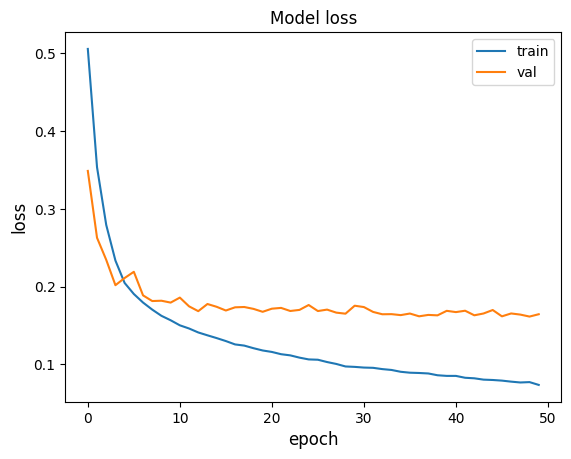

In [ ]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
5predictor.model.evaluate(x_test, y_test, return_dict=True)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9389 - f1_score: 0.5009 - fn: 972.1455 - fp: 831.9776 - loss: 0.1652 - tn: 19174.6992 - tp: 9053.1602


{'accuracy': 0.940850019454956,
 'f1_score': 0.5010866522789001,
 'fn': 1931.0,
 'fp': 1618.0,
 'loss': 0.16155590116977692,
 'tn': 38324.0,
 'tp': 18127.0}

True positive rate: 90.567354671452786917937979858411%

True negative rate: 97.316108357117820840218316559011%

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step


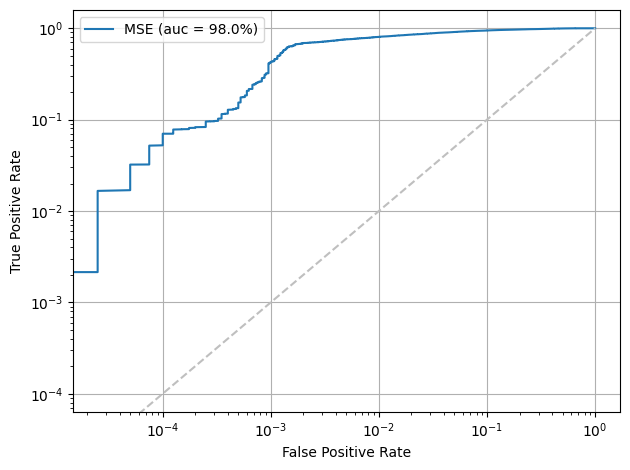

In [ ]:
def make_plot_roc_curves(model, x_test, y_test):

    true_val = y_test
    pred_val = model.predict(x_test)

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    # qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

make_plot_roc_curves(predictor, x_test, y_test)

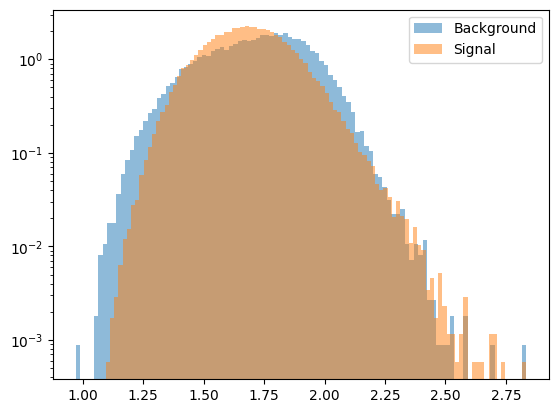

In [ ]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [ ]:
__file__='/content/drive/MyDrive/Colab Notebooks/'
model_test = Model()
model_test.load()

model_test.model.summary()
model_test.model.evaluate(x_test, y_test, return_dict=True)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 200, 2)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 200, 2)         │          1,410 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 200, 2)         │              4 │ dropout_21[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 200, 64)        │            192 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 200, 64)        │              0 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 200, 2)         │            130 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 200, 2)         │              4 │ conv1d_9[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 200, 2)         │          1,410 │ add_11[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 200, 2)         │              4 │ dropout_24[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 200, 64)        │            192 │ add_12[0][0]           │
├──────────────────────

 Total params: 444,749 (1.70 MB)

 Trainable params: 148,249 (579.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 296,500 (1.13 MB)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 149s 78ms/step - accuracy: 0.9568 - f1_score: 0.5009 - fn: 719.2601 - fp: 556.4051 - loss: 0.1422 - tn: 19450.2715 - tp: 9306.0449


{'accuracy': 0.958050012588501,
 'f1_score': 0.5010866522789001,
 'fn': 1422.0,
 'fp': 1095.0,
 'loss': 0.13774757087230682,
 'tn': 38847.0,
 'tp': 18636.0}

In [ ]:
model_test.model.evaluate(background, np.zeros((len(background), 1)), return_dict=True)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 245s 78ms/step - accuracy: 0.9901 - f1_score: 0.0000e+00 - fn: 0.0000e+00 - fp: 497.9607 - loss: 0.0348 - tn: 49534.0273 - tp: 0.0000e+00


{'accuracy': 0.990119993686676,
 'f1_score': 0.0,
 'fn': 0.0,
 'fp': 988.0,
 'loss': 0.0351204015314579,
 'tn': 99012.0,
 'tp': 0.0}

In [ ]:
model_test.model.evaluate(bbh, np.zeros((len(bbh), 1)), return_dict=True)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 244s 78ms/step - accuracy: 0.9964 - f1_score: 0.0000e+00 - fn: 0.0000e+00 - fp: 172.8999 - loss: 0.0112 - tn: 49859.0898 - tp: 0.0000e+00


{'accuracy': 0.9965199828147888,
 'f1_score': 0.0,
 'fn': 0.0,
 'fp': 348.0,
 'loss': 0.011113300919532776,
 'tn': 99652.0,
 'tp': 0.0}

In [ ]:
model_test.model.evaluate(sglf, np.ones((len(sglf), 1)), return_dict=True)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 246s 79ms/step - accuracy: 0.9776 - f1_score: 1.0000 - fn: 1116.0717 - fp: 0.0000e+00 - loss: 0.0769 - tn: 0.0000e+00 - tp: 48915.9180


{'accuracy': 0.9784500002861023,
 'f1_score': 1.0,
 'fn': 2155.0,
 'fp': 0.0,
 'loss': 0.07418987154960632,
 'tn': 0.0,
 'tp': 97845.0}

In [ ]:
transformer_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/transformer_model.keras")
transformer_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 200, 2)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_4    │ (None, 200, 2)         │          1,410 │ input_layer_2[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 200, 2)         │              4 │ dropout_21[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 200, 64)        │            192 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 200, 64)        │              0 │ conv1d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 200, 2)         │            130 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_15    │ (None, 200, 2)         │              4 │ conv1d_9[0][0]         │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_5    │ (None, 200, 2)         │          1,410 │ add_11[0][0],          │
│ (MultiHeadAttention)      │                        │                │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 200, 2)         │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_16    │ (None, 200, 2)         │              4 │ dropout_24[0][0]       │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 200, 2)         │              0 │ layer_normalization_1… │
│                           │                        │                │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 200, 64)        │            192 │ add_12[0][0]           │
├──────────────────────

 Total params: 444,749 (1.70 MB)

 Trainable params: 148,249 (579.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 296,500 (1.13 MB)

In [ ]:
cov_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/cov_model.keras")
cov_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 37, 37, 8)           │           3,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 37, 37, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 12, 12, 8)           │              16 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 1)             │           1,153 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,133 (51.30 KB)

 Trainable params: 4,377 (17.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,756 (34.21 KB)

In [ ]:
ssa_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ssa_model.keras")
ssa_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 101, 100, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 46, 46, 8)           │          12,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 46, 46, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 15, 15, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 15, 15, 8)           │              16 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 1, 1)             │           1,801 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,877 (171.40 KB)

 Trainable params: 14,625 (57.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,252 (114.27 KB)

In [ ]:
class Model:
    def __init__(self):
        super().__init__()

    def model_combinator(self, transformer_inputs, cov_inputs, ssa_inputs, dropout, l1):
      x = layers.Concatenate(axis=1)([transformer_inputs, cov_inputs, ssa_inputs])
      print(f"Concatenated shape: {x.shape}")
      x = layers.Dropout(dropout)(x)
      x = layers.LayerNormalization(epsilon=1e-6)(x)
      x = layers.Dense(8, activation="relu", kernel_regularizer=regularizers.L1(l1))(x)
      x = layers.Dropout(dropout)(x)
      x = layers.LayerNormalization(epsilon=1e-6)(x)
      x = layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.L1(l1))(x)
      return x

    def build_model(self, transformer_input_shape, cov_input_shape, ssa_input_shape, dropout=0, l1=0):
        transformer_inputs = keras.Input(shape=transformer_input_shape)
        cov_inputs = keras.Input(shape=cov_input_shape)
        ssa_inputs = keras.Input(shape=ssa_input_shape)

        self.transformer_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/transformer_model.keras")
        self.cov_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/cov_model.keras")
        self.ssa_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ssa_model.keras")

        for layer in self.transformer_model.layers:
          if isinstance(layer, layers.Dense) or isinstance(layer, layers.Conv1D) or isinstance(layer, layers.MultiHeadAttention):
            layer.kernel_regularizer = regularizers.L1(l1)
        self.transformer_model.layers[-1].activation = keras.activations.linear
        self.transformer_model.name = 'transformer_model'
        self.transformer_model.compile()

        for layer in self.cov_model.layers:
          if isinstance(layer, layers.Conv2D):
            layer.kernel_regularizer = regularizers.L1(l1)
        self.cov_model.layers[-2].activation = keras.activations.linear
        self.cov_model.name = 'covariance_model'
        self.cov_model.compile()

        for layer in self.ssa_model.layers:
          if isinstance(layer, layers.Conv2D):
            layer.kernel_regularizer = regularizers.L1(l1)
        self.ssa_model.layers[-2].activation = keras.activations.linear
        self.ssa_model.name = 'ssa_model'
        self.ssa_model.compile()

        transformer_outputs = self.transformer_model(transformer_inputs)
        cov_outputs = self.cov_model(cov_inputs)
        ssa_outputs = self.ssa_model(ssa_inputs)
        outputs = self.model_combinator(transformer_outputs, cov_outputs, ssa_outputs, dropout, l1)

        metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                   keras.metrics.TruePositives(name='tp'),
                   keras.metrics.FalsePositives(name='fp'),
                   keras.metrics.TrueNegatives(name='tn'),
                   keras.metrics.FalseNegatives(name='fn')]

        self.model = keras.Model(inputs=[transformer_inputs, cov_inputs, ssa_inputs], outputs=outputs)
        self.model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                           metrics=metrics)

    def predict(self, X, batch_size=32):
        return np.where(self.model.predict(X, batch_size=batch_size) >= 0.5, 1, 0)

    def __call__(self, inputs, batch_size=64):
        return self.model.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.model.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.model = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, y_train, epochs=1, validation_split=0.0, **kwargs):
      L = 100 # The window length.
      K = x_train.shape[1] - L + 1

      if validation_split > 0:
        x_train, x_val, y_train, y_val = train_test_split(
            data, labels, test_size=validation_split, random_state=42)

      if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']
      else:
        batch_size = 1

      if 'num_components' in kwargs:
        num_components = kwargs['num_components']
      else:
        num_components = 8

      for i in range(epochs):
        print(f"Epoch {i + 1}/{epochs}:")
        num_batches = int(np.ceil(x_train.shape[0]/batch_size))
        training_metrics = np.zeros(6)
        batch_index = 0
        training_loss = 0.0
        training_accuracy = 0.0
        training_tp = 0.0
        training_tn = 0.0
        training_fp = 0.0
        training_fn = 0.0
        val_loss = 0.0
        val_accuracy = 0.0
        val_tp = 0.0
        val_tn = 0.0
        val_fp = 0.0
        val_fn = 0.0

        for batch_number in range(num_batches):
          batch_x, batch_y = x_train[batch_index:min(batch_index + batch_size, x_train.shape[0])], y_train[batch_index:min(batch_index + batch_size, y_train.shape[0])]

          X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

          X = np.moveaxis(X, -1, -3)

          U, Sigma, V = np.linalg.svd(X)
          V = V.T

          svd_matrix_list = []

          cov_matrix_list = []

          for j in range(batch_x.shape[0]):
            cov_matrix_list.append(np.cov(batch_x[j]))

            batch_svd = []
            for z in range(0, num_components):
              batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])

            svd_matrix_list.append(np.array(batch_svd))

          cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

          svd_matrix = np.moveaxis(np.stack(svd_matrix_list), -3, -1)

          # print(f"Processing batch {batch_number + 1}/{num_batches}")
          training_metrics = self.model.train_on_batch(x=[batch_x, cov_matrix, svd_matrix], y=batch_y, class_weight={0:0.67, 1:1.33}, return_dict=True)
          training_loss += training_metrics['loss']/num_batches
          training_accuracy += training_metrics['accuracy']/num_batches
          training_tp += training_metrics['tp']
          training_tn += training_metrics['tn']
          training_fp += training_metrics['fp']
          training_fn += training_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Training metrics: loss = {training_loss}, accuracy = {training_accuracy}, TP = {training_tp}, TN = {training_tn}, FP = {training_fp}, FN = {training_fn}")

        num_batches = int(np.ceil(x_val.shape[0]/batch_size))
        val_metrics = np.zeros(6)
        batch_index = 0
        for batch_number in range(num_batches):
          batch_x, batch_y = x_val[batch_index:min(batch_index + batch_size, x_val.shape[0])], y_val[batch_index:min(batch_index + batch_size, y_val.shape[0])]
          X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

          X = np.moveaxis(X, -1, -3)

          U, Sigma, V = np.linalg.svd(X)
          V = V.T

          svd_matrix_list = []

          cov_matrix_list = []

          for j in range(batch_x.shape[0]):
            cov_matrix_list.append(np.cov(batch_x[j]))

            batch_svd = []
            for z in range(0, num_components):
              batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])

            svd_matrix_list.append(np.array(batch_svd))

          cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

          svd_matrix = np.moveaxis(np.stack(svd_matrix_list), -3, -1)

          val_metrics = self.model.test_on_batch(x=[batch_x, cov_matrix, svd_matrix], y=batch_y, return_dict=True)
          val_loss += val_metrics['loss']/num_batches
          val_accuracy += val_metrics['accuracy']/num_batches
          val_tp += val_metrics['tp']
          val_tn += val_metrics['tn']
          val_fp += val_metrics['fp']
          val_fn += val_metrics['fn']
          batch_index += batch_size

          self.model.reset_metrics()

        print(f"Validation metrics: loss = {val_loss}, accuracy = {val_accuracy}, TP = {val_tp}, TN = {val_tn}, FP = {val_fp}, FN = {val_fn}")

      return training_metrics, val_metrics

# Example usage:
transformer_input_shape = (200, 2)
cov_input_shape = (200, 200, 1)
ssa_input_shape = (101, 100, 16)
dropout = 0.1
l1 = 0.1

# build the model
predictor = Model()
predictor.build_model(
    transformer_input_shape=transformer_input_shape,
    cov_input_shape=cov_input_shape,
    ssa_input_shape=ssa_input_shape,
    dropout=dropout,
    l1=l1
)

# Assuming x_train is your input data
predictor.load()
history = predictor.fit(
    x_train,
    y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Concatenated shape: (None, 3)
Epoch 1/10:
Training metrics: loss = 120.92408948262529, accuracy = 0.8969583333333355, TP = 6816.0, TN = 14711.0, FP = 1291.0, FN = 1182.0
Validation metrics: loss = 6.1293788590329745, accuracy = 0.828789893617024, TP = 1924.0, TN = 3047.0, FP = 951.0, FN = 78.0
Epoch 2/10:


KeyboardInterrupt: 

In [ ]:
__file__='saved_model'
!mkdir -p saved_model
predictor.save('')

In [ ]:
final_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/final_model.keras")
final_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 200, 2)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 200, 200, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 101, 100, 16)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_model         │ (None, 1)              │        148,249 │ input_layer_3[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ covariance_model          │ (None, 1)              │          4,377 │ input_layer_4[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ssa_model (Functional)    │ (None, 1)              │         14,625 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 3)              │              0 │ transformer_model[0][… │
│ (Concatenate)             │                        │                │ covariance_model[0][0… │
│                           │                        │                │ ssa_model[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 3)              │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 3)              │              6 │ dropout_6[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │             32 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 8)              │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 8)              │             16 │ dropout_7[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │              9 │ layer_normalization_3… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 501,944 (1.91 MB)

 Trainable params: 167,314 (653.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 334,630 (1.28 MB)

In [ ]:
def evaluate(model, eval_x, eval_y, batch_size=32):
  L = 100 # The window length.
  K = x_train.shape[1] - L + 1

  num_batches = int(np.ceil(eval_x.shape[0]/batch_size))
  num_components = 8
  eval_metrics = np.zeros(6)
  batch_index = 0
  eval_loss = 0.0
  eval_accuracy = 0.0
  eval_tp = 0.0
  eval_tn = 0.0
  eval_fp = 0.0
  eval_fn = 0.0

  for batch_number in range(num_batches):
    batch_x, batch_y = eval_x[batch_index:min(batch_index + batch_size, eval_x.shape[0])], eval_y[batch_index:min(batch_index + batch_size, eval_y.shape[0])]
    X = np.stack([batch_x[:, i:i+L] for i in range(0,K)], axis=1)

    X = np.moveaxis(X, -1, -3)

    U, Sigma, V = np.linalg.svd(X)
    V = V.T

    svd_matrix_list = []

    cov_matrix_list = []

    for j in range(batch_x.shape[0]):
      cov_matrix_list.append(np.cov(batch_x[j]))

      batch_svd = []
      for z in range(0, num_components):
        batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])

      svd_matrix_list.append(np.array(batch_svd))

    cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

    svd_matrix = np.moveaxis(np.stack(svd_matrix_list), -3, -1)

    eval_metrics = model.test_on_batch(x=[batch_x, cov_matrix, svd_matrix], y=batch_y, return_dict=True)
    eval_loss += eval_metrics['loss']/num_batches
    eval_accuracy += eval_metrics['accuracy']/num_batches
    eval_tp += eval_metrics['tp']
    eval_tn += eval_metrics['tn']
    eval_fp += eval_metrics['fp']
    eval_fn += eval_metrics['fn']
    batch_index += batch_size

    model.reset_metrics()

  print(f"Evaluation metrics: loss = {eval_loss}, accuracy = {eval_accuracy}, TP = {eval_tp}, TN = {eval_tn}, FP = {eval_fp}, FN = {eval_fn}")

In [ ]:
evaluate(final_model, x_test, y_test)

Evaluation metrics: loss = 841.7839490559907, accuracy = 0.9789500000000327, TP = 19334.0, TN = 39403.0, FP = 539.0, FN = 724.0


True positive rate: 96.4%

True negative rate: 98.7%

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Model():
    def __init__(self):
        super().__init__()
        self.L = 100
        self.K = 0
        self.num_components = 8

    def load(self):
        self.model = keras.models.load_model('model.keras')

    def predict(self, X, batch_size=32):
        self.K = X.shape[1] - self.L + 1
        output_array = np.empty(X.shape[0])
        num_batches = int(np.ceil(X.shape[0]/batch_size))
        batch_index = 0
        for batch_number in range(num_batches):
            batch_X = X[batch_index:min(batch_index + batch_size, X.shape[0])]
            A = np.stack([batch_X[:, i:i + self.L] for i in range(0, self.K)], axis=1)

            A = np.moveaxis(A, -1, -3)

            U, Sigma, V = np.linalg.svd(A)
            V = V.T

            svd_matrix_list = []

            cov_matrix_list = []

            for j in range(batch_X.shape[0]):
                cov_matrix_list.append(np.cov(batch_X[j]))

                batch_svd = []
                for z in range(0, self.num_components):
                    batch_svd.extend([Sigma[j, 0, z] * np.outer(U[j, 0, :,z], V[:,z, 0, j]), Sigma[j, 1, z] * np.outer(U[j, 1, :,z], V[:,z, 1, j])])

                svd_matrix_list.append(np.array(batch_svd))

            cov_matrix = np.stack(cov_matrix_list)[:, :, :, np.newaxis]

            svd_matrix = np.moveaxis(np.stack(svd_matrix_list), -3, -1)

            output_array[batch_index:min(batch_index + batch_size, X.shape[0])] = self.model.predict_on_batch([batch_X, cov_matrix, svd_matrix]).flatten()

            batch_index += batch_size

In [ ]:
test_model = Model()
test_model.load()
test_model.predict(x_test)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


(1000,)
(1000,)
[0.61783636 0.06520917 0.06514546 0.96586955 0.06623014 0.07012574
 0.96462172 0.06493014 0.06541059 0.96583974 0.06596761 0.0658012
 0.06497309 0.96575594 0.06529481 0.96490353 0.96494418 0.96579063
 0.96387255 0.96487057 0.0648551  0.96583498 0.06702248 0.06526612
 0.06544814 0.88853091 0.06486773 0.96530992 0.06512125 0.96529281
 0.06580982 0.96581674 0.06533225 0.96300817 0.96329856 0.96536517
 0.08400885 0.06729643 0.07868019 0.06588446 0.06690144 0.06542415
 0.07790749 0.06514713 0.07960579 0.06538887 0.06586667 0.06494811
 0.06490632 0.96550727 0.06485034 0.06892884 0.96529341 0.06685377
 0.06583526 0.96441823 0.06611542 0.06559069 0.06535684 0.965859
 0.9652313  0.06548595 0.06642743 0.06574033 0.06541605 0.06521782
 0.0657862  0.9653796  0.06828872 0.06607813 0.06510006 0.06534126
 0.06485304 0.06511784 0.06730389 0.96473712 0.13175115 0.06542833
 0.95993763 0.0660178  0.07911245 0.06675601 0.96067923 0.06558736
 0.9642086  0.06628148 0.0661201  0.12257443 0.06